In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
import json

# Training dataset importing

In [2]:
cnn_samples0 = pd.read_csv('cnn_samples-54b19b96f3c0775b116bad527df8c7b5.csv')

# Wrangling the data from strings to NP arrays.
cnn_samples1 = np.fromstring((cnn_samples0.values[0,3]).replace('[','').replace(']',''), sep=',').reshape(1,512)

# Rebuilding the DataFrame after this, with headline as index.
for i in np.arange(1,np.shape(cnn_samples0)[0]):
    temp = np.fromstring((cnn_samples0.values[i,3]).replace('[','').replace(']',''), sep=',').reshape(1,512)
    cnn_samples1 = np.vstack([cnn_samples1, temp])
cnn_samples = pd.DataFrame(cnn_samples1, index = cnn_samples0['text'])

#Repeating the process for the challenge data.
gov_samples0 = pd.read_csv('federal_samples-a586d0681e005629453435bea5b173eb.csv')
gov_samples1 = np.fromstring((gov_samples0.values[0,3]).replace('[','').replace(']',''), sep=',').reshape(1,512)
for i in np.arange(1,np.shape(gov_samples0)[0]):
    temp = np.fromstring((gov_samples0.values[i,3]).replace('[','').replace(']',''), sep=',').reshape(1,512)
    gov_samples1 = np.vstack([gov_samples1, temp])
gov_samples = pd.DataFrame(gov_samples1, index = gov_samples0['text'])

#also need to merge the two DataFrames
cnngov_samples = pd.concat([cnn_samples, gov_samples], axis = 'rows')

#Repeating the process for the challenge data.
challenge0 = pd.read_csv('challenge-ddec63cf66ea88f128e3c21e457f393a.csv')
challenge1 = np.fromstring((challenge0.values[0,1]).replace('[','').replace(']',''), sep=',').reshape(1,512)
for i in np.arange(1,np.shape(challenge0)[0]):
    temp = np.fromstring((challenge0.values[i,1]).replace('[','').replace(']',''), sep=',').reshape(1,512)
    challenge1 = np.vstack([challenge1, temp])
challenge = pd.DataFrame(challenge1, index = challenge0['id'])


#Finally, getting the mystery 6th article.
with open('mystery.json') as file:
    mystery0 = json.load(file)['embedding']

mystery = pd.DataFrame(np.array(mystery0).reshape(1,512), index = ['mystery'], columns = np.arange(0,512)) #it's a dict

#also need to merge these two DataFrames
challenge = pd.concat([challenge, mystery], axis = 'rows')

#print(cnngov_samples.head()) #just double-checking
#print(challenge.head())

# Distances (Adjacency matrix)

In [3]:
#from scipy import spatial

#def cos_similarity(a, b):
#    return 1 - spatial.distance.cosine(a, b)

#AdjacencyCos = np.array([ cos_similarity( cnngov_samples.values[0], cnngov_samples.values[c]) for c in np.arange(0,len(cnngov_samples)) ]).reshape(1,len(cnngov_samples))

#for i in np.arange(1,len(cnngov_samples)):
#    temp = np.array([ cos_similarity( cnngov_samples.values[i], cnngov_samples.values[c]) for c in np.arange(0,len(cnngov_samples)) ]).reshape(1,len(cnngov_samples))
#    AdjacencyCos = np.vstack([AdjacencyCos, temp])

#print(AdjacencyCos)

#Alternatively, could use the usual Euclidean metric:
#spatial.distance.euclidean(cnngov_samples.values[i], cnngov_samples.values[c])

# Trying K-means

<class 'numpy.ndarray'>
[ 9 52 11 54 62 58]


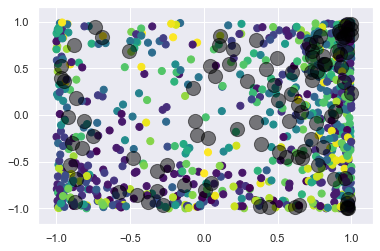

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100)
kmeans.fit(cnngov_samples)
y_kmeans = kmeans.predict(cnngov_samples) #in addition to coloring, we can use these to make Boolean masks to view contents of each cluster KM predicted for the challenge articles.
print(type(y_kmeans))

plt.scatter(cnngov_samples.values[:, 0], cnngov_samples.values[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

#the moment of truth
challengeKM = kmeans.predict(challenge)
print(challengeKM)

#great, let's mask the original cnngov_sample DataSeries with Boolean arrays generated by y_kmeans
article1KM = y_kmeans == challengeKM[0]
article2KM = y_kmeans == challengeKM[1]
article3KM = y_kmeans == challengeKM[2]
article4KM = y_kmeans == challengeKM[3]
article5KM = y_kmeans == challengeKM[4]
article6KM = y_kmeans == challengeKM[5]

clusterArticle1KM = cnngov_samples[article1KM].index.values.tolist()
clusterArticle2KM = cnngov_samples[article2KM].index.values.tolist()
clusterArticle3KM = cnngov_samples[article3KM].index.values.tolist()
clusterArticle4KM = cnngov_samples[article4KM].index.values.tolist()
clusterArticle5KM = cnngov_samples[article5KM].index.values.tolist()
clusterArticle6KM = cnngov_samples[article6KM].index.values.tolist()

#print()

# Trying K-Nearest Neighbor with a TF-IDF Vectorizer as Target Array (to count/weigh important words)

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# TF-IDF word frequency counter (for headlines)
vec = TfidfVectorizer()
cnnX = vec.fit_transform(pd.concat([cnn_samples0['text'],gov_samples0['text']]))
Y = pd.DataFrame(cnnX.toarray(), columns=vec.get_feature_names())
Y = Y.drop(columns = stopwords.words('english'), errors = 'ignore') #remove filler words (Stopwords)

top_n = 12 #return the top N words from each source, except the WordCloud Stopwords.
Z = pd.DataFrame({n: Y.T[col].nlargest(top_n).index.tolist() 
                  for n, col in enumerate(Y.T)}).T

print(Z)

#Z.apply(np.sort, axis = 'columns')
#print(Z)

#Z = Y.apply(p.Series.nlargest, axis = 1, n)

#Z = Y.idxmax(axis = 'columns') #highest for each

knnModel = KNeighborsClassifier(n_neighbors= 8, algorithm = 'auto', p = 2, metric = 'minkowski')
knnModel.fit(cnngov_samples, Z)

print('Probability estimates for the test data:')
print(knnModel.predict_proba(challenge))

# the moment of truth...
challengeKNN = knnModel.kneighbors(challenge, n_neighbors = 8, return_distance = True)
print('The challenge articles\' 5 nearest neighbors according to the KNN algorithm:')
print(challengeKNN[1])

article1KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,7])
article2KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,7])
article3KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,7])
article4KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,7])
article5KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,7])
article6KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,7])

clusterArticle1KNN = cnngov_samples[article1KNN].index.values.tolist()
clusterArticle2KNN = cnngov_samples[article2KNN].index.values.tolist()
clusterArticle3KNN = cnngov_samples[article3KNN].index.values.tolist()
clusterArticle4KNN = cnngov_samples[article4KNN].index.values.tolist()
clusterArticle5KNN = cnngov_samples[article5KNN].index.values.tolist()
clusterArticle6KNN = cnngov_samples[article6KNN].index.values.tolist()

print('Each of those nearest neighbor\'s most frequent words:')

print(Z[article1KNN])
print(Z[article2KNN])
print(Z[article3KNN])
print(Z[article4KNN])
print(Z[article5KNN])
print(Z[article6KNN])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mashb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                0               1              2              3   \
0           cheney           heart           pump           vice   
1            minaj          school       students         rapper   
2          buffett          morgan         wallet       kathleen   
3              dog        melville           dogs          trinh   
4         pakistan        military      pakistani         gilani   
5         bachchan            film         actors         cinema   
6         pakistan      assemblies     provincial  parliamentary   
7          coronel          guzman        sinaloa         cartel   
8             isis           obama          syria      americans   
9         hydrogen           buses       seaworld        orlando   
10            pink             dum             da        panther   
11        football           clubs         madrid        spanish   
12       guatemala           pilot         zacapa          plane   
13       guardiola       barcelona           dra

# Trying Nearest Neighbor (unsupervised)

In [6]:
from sklearn.neighbors import NearestNeighbors

nnModel = NearestNeighbors(n_neighbors= 5, algorithm = 'auto', p = 2, metric = 'minkowski')
nnModel.fit(cnngov_samples)

print(nnModel.get_params())

# the moment of truth...
challengeNN = nnModel.kneighbors(challenge)
print(challengeNN)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'radius': 1.0}
(array([[11.78524408, 11.9716836 , 12.04280484, 12.12346722, 12.14904002],
       [ 4.92278543, 13.05281882, 14.10067347, 14.2341641 , 14.31238954],
       [ 5.11376029,  5.66676187,  6.46962392,  6.72294013,  7.71811338],
       [ 5.29819071,  6.10008504,  6.43333888,  6.57300171,  6.80982475],
       [ 5.9169947 ,  6.61718959,  6.75509548,  6.78793639,  7.01699374],
       [ 9.35102298,  9.55616729,  9.60899041,  9.62128386, 10.03504164]]), array([[ 67, 530, 657, 428, 673],
       [133, 542, 105, 496, 124],
       [ 64,  75,  29, 339,  69],
       [659, 480,  89, 223, 567],
       [705, 419, 446, 274, 511],
       [144,  35, 286, 261, 469]], dtype=int64))


# Trying Gaussian Mixtures

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[ 4  9 10 11  5  4]


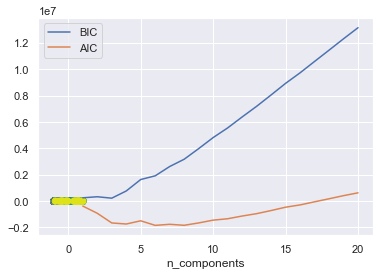

In [7]:
from sklearn.mixture import GaussianMixture

gmModel = GaussianMixture(n_components=20, covariance_type="full").fit(cnngov_samples)
labels = gmModel.predict(cnngov_samples)
plt.scatter(cnngov_samples.values[:, 0], cnngov_samples.values[:, 1], c=labels, s=40, cmap='viridis')

#Giving each components' densities for this sample data
print(gmModel.predict_proba(challenge))


#Giving the Akaike and Bayesian information criteria for this model on the sample data, to help decide the # of components.
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cnngov_samples)
          for n in n_components]

plt.plot(n_components, [m.bic(cnngov_samples) for m in models], label='BIC')
plt.plot(n_components, [m.aic(cnngov_samples) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');



# the moment of truth...
challengeGM = gmModel.predict(challenge)
print(challengeGM)

# On a side note, I'm very curious to see if these generated embeddings correspond to anything...
# print(gmModel.sample(5))